In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
torch:  2.4 ; cuda:  cu118
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, r"D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/train/_annotations.coco.json", r"D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/train")
register_coco_instances("my_dataset_val", {}, r"D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/valid/_annotations.coco.json", r"D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/valid")

In [4]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [09/12 15:36:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/12 15:36:38 d2.data.datasets.coco]: Loaded 2478 images in COCO format from D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/train/_annotations.coco.json


In [5]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


WARNING [09/12 15:36:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/12 15:36:38 d2.data.datasets.coco]: Loaded 101 images in COCO format from D:/HaxS/Dataset/Car dentss.v1i.coco-segmentation/valid/_annotations.coco.json


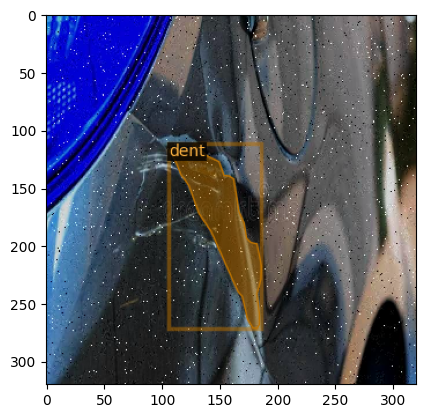

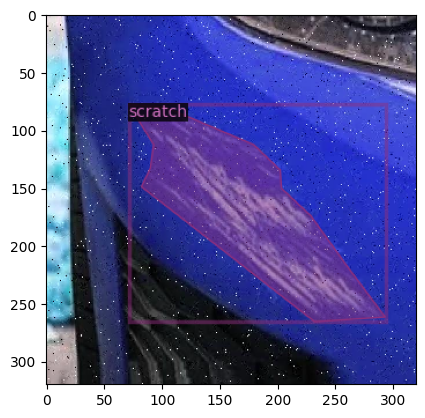

In [6]:
from matplotlib import pyplot as plt

# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "D:\HaxS\Models\Mini"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[09/12 15:36:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [8]:
trainer.train()

[09/12 15:36:39 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\MUJ\conda3\envs\detectron_env\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/12 15:36:44 d2.utils.events]:  eta: 0:02:05  iter: 19  total_loss: 2.266  loss_cls: 1.146  loss_box_reg: 0.2344  loss_mask: 0.6944  loss_rpn_cls: 0.2085  loss_rpn_loc: 0.03372    time: 0.1307  last_time: 0.1287  data_time: 0.0972  last_data_time: 0.0009   lr: 4.9953e-06  max_mem: 1568M
[09/12 15:36:47 d2.utils.events]:  eta: 0:02:04  iter: 39  total_loss: 2.092  loss_cls: 1.025  loss_box_reg: 0.2195  loss_mask: 0.6923  loss_rpn_cls: 0.1733  loss_rpn_loc: 0.01619    time: 0.1301  last_time: 0.1398  data_time: 0.0010  last_data_time: 0.0005   lr: 9.9902e-06  max_mem: 1568M
[09/12 15:36:49 d2.utils.events]:  eta: 0:02:01  iter: 59  total_loss: 1.979  loss_cls: 0.8094  loss_box_reg: 0.243  loss_mask: 0.6882  loss_rpn_cls: 0.1666  loss_rpn_loc: 0.02397    time: 0.1293  last_time: 0.1098  data_time: 0.0010  last_data_time: 0.0005   lr: 1.4985e-05  max_mem: 1639M
[09/12 15:36:52 d2.utils.events]:  eta: 0:01:58  iter: 79  total_loss: 1.592  loss_cls: 0.5811  loss_box_reg: 0.1832  loss_mask

In [10]:
import yaml
config_yaml_path = "D:\HaxS\Models\Mini\config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)